In [1]:
import os
import json
from tqdm.notebook import tqdm
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
def get_doc_texts():
    docs = {}

    with open('../dataset/docs.json', 'r') as docs_file:
        progress_bar = tqdm(total=os.path.getsize('../dataset/docs.json'), unit='B', unit_scale=True, unit_divisor=1024, desc='Loading docs') 

        for line in docs_file:
            doc = json.loads(line)
            docs[doc['id']] = doc['text']
            
            progress_bar.update(len(line))

    return docs

def get_dataset():
    doc_texts = get_doc_texts()

    docs_df = pd.read_csv("../dataset/docs.csv").astype('string')

    batch = []
    for index, row in docs_df.iterrows():
        if not row.doc1_id in doc_texts or not row.doc2_id in doc_texts:
            continue

        batch.append({
            "doc1": {
                "id": row.doc1_id,
                "text": doc_texts[row.doc1_id]
            },
            "doc2": {
                "id": row.doc2_id,
                "text": doc_texts[row.doc2_id]
            },
            "score": float(row.score)
        })

    train, test = train_test_split(batch, test_size=0.2, random_state=42)
    return train, test


In [4]:
doc_texts = get_doc_texts()

docs_df = pd.read_csv("../dataset/docs.csv").astype('string')

batch = []
for index, row in docs_df.iterrows():
    if not row.doc1_id in doc_texts or not row.doc2_id in doc_texts:
        continue

    batch.append({
        "doc1": {
            "id": row.doc1_id,
            "text": doc_texts[row.doc1_id]
        },
        "doc2": {
            "id": row.doc2_id,
            "text": doc_texts[row.doc2_id]
        },
        "score": float(row.score)
    })

data = batch
nodes = {}

for edge in data:
    nodes[edge['doc1']['id']] = edge['doc1']['text']
    nodes[edge['doc2']['id']] = edge['doc2']['text']

node_id_to_index_map = {node: i for i, node in enumerate(nodes.keys())}

print("num_nodes: ", len(nodes))

edges = []

for edge in data:
    n1 = node_id_to_index_map[edge['doc1']['id']]
    n2 = node_id_to_index_map[edge['doc2']['id']]
    edges.append([n1, n2])
    edges.append([n2, n1])

edges_tensor = torch.tensor(edges, dtype=torch.long).t().contiguous()

graph_data = Data(edge_index=edges_tensor, num_nodes=len(nodes))

print('is unidirected: ', graph_data.is_undirected())




num_nodes:  4320
is unidirected:  True


In [5]:
graph_data

Data(edge_index=[2, 676466], num_nodes=4320)

In [3]:
train, test = get_dataset()

In [4]:
import os, sys
sys.path.append(os.path.abspath('..'))

In [5]:
from model.model import SemanticSimilarityModel

In [6]:
similarity_model = SemanticSimilarityModel()
similarity_model.load('with_classifier')

In [7]:
# node id to text dictionary
nodes = {}

for edge in train:
    nodes[edge['doc1']['id']] = edge['doc1']['text']
    nodes[edge['doc2']['id']] = edge['doc2']['text']

In [8]:
node_id_to_index_map = {node: i for i, node in enumerate(nodes.keys())}

print("num_nodes: ", len(nodes))

num_nodes:  4196


In [3]:
import torch
from torch_geometric.data import Data

In [10]:
edges = []

for edge in train:
    n1 = node_id_to_index_map[edge['doc1']['id']]
    n2 = node_id_to_index_map[edge['doc2']['id']]
    edges.append([n1, n2])
    edges.append([n2, n1])

edges_tensor = torch.tensor(edges, dtype=torch.long).t().contiguous()

In [11]:
graph_data = Data(edge_index=edges_tensor, num_nodes=len(nodes))

print('is unidirected: ', graph_data.is_undirected())
graph_data

is unidirected:  True


Data(edge_index=[2, 541172], num_nodes=4196)

In [12]:
graph_data = Data(edge_index=edges_tensor, num_nodes=len(nodes))

print('is unidirected: ', graph_data.is_undirected())
graph_data

is unidirected:  True


Data(edge_index=[2, 541172], num_nodes=4196)

In [13]:
import pickle

In [14]:
x = []

def encode_x():
    def encode(v):
        e = similarity_model.encode(v)
        padding_length = len(e[0]) - len(e[2])
        pad = torch.zeros(padding_length)
        e[2] = torch.cat((e[2], pad))
        return torch.tensor(e)

    for v in tqdm(nodes.values()):
        x.append(encode(v))

    with open(f'x', 'wb') as f:
        pickle.dump(x, f)

try:
    with open(f'x', 'rb') as f:
        x = pickle.load(f)
except:
    encode_x()

In [15]:
x_tensor = torch.stack(x, dim=0)

In [16]:
graph_data.x = x_tensor.to(torch.float).reshape(-1, 3*768)

In [17]:
graph_data

Data(edge_index=[2, 541172], num_nodes=4196, x=[4196, 2304])

In [18]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GraphConv
from torch_geometric.utils import negative_sampling

class GCN(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, 1000)
        self.conv2 = GCNConv(1000, 3000)
        self.conv3 = GCNConv(3000, 1000)
        self.conv4 = GCNConv(1000, num_classes)
        self.dropout = torch.nn.Dropout(p=0.5)  # Create a dropout layer

    def forward(self, x, edge_index):
        x = F.relu(self.dropout(self.conv1(x, edge_index)))
        x = F.relu(self.dropout(self.conv2(x, edge_index)))
        x = F.relu(self.dropout(self.conv3(x, edge_index)))
        x = self.conv4(x, edge_index)
        return torch.sigmoid(x)


model = GCN(num_features=2304, num_classes=1)

In [19]:
def train_model(epochs = 1, t = None):
    optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001) 
    criterion = torch.nn.BCELoss()
    loss_list = []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        # Forward pass for positive samples
        pred_pos = model(graph_data.x, graph_data.edge_index).squeeze()
    
        # Predictions for negative samples
        edge_index_neg = negative_sampling(graph_data.edge_index, num_nodes=graph_data.num_nodes, num_neg_samples=graph_data.edge_index.size(1))

        pred_neg = model(graph_data.x, edge_index_neg).squeeze()

        # Combine positive and negative predictions and create labels accordingly
        pred_all = torch.cat([pred_pos, pred_neg], dim=0)
        labels = torch.cat([torch.ones(pred_pos.size(0)), torch.zeros(pred_neg.size(0))], dim=0)

        # Calculate loss, perform backpropagation, and update model parameters
        loss = criterion(pred_all, labels)
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())
        
        if t is None:            
            print(f'Epoch {epoch+1}: Loss = {loss.item()}')
        else:
            print(f'Epoch {epoch+1}: Loss = {loss.item()} Test = {t()}')
train_model()

Epoch 1: Loss = 0.6930904388427734


In [20]:
pred_pos = model(graph_data.x, graph_data.edge_index).squeeze()

In [21]:
def transform_to_graph(data):
    nodes = {}

    for edge in data:
        nodes[edge['doc1']['id']] = edge['doc1']['text']
        nodes[edge['doc2']['id']] = edge['doc2']['text']

    node_id_to_index_map = {node: i for i, node in enumerate(nodes.keys())}

    print("num_nodes: ", len(nodes))
    
    edges = []

    for edge in data:
        n1 = node_id_to_index_map[edge['doc1']['id']]
        n2 = node_id_to_index_map[edge['doc2']['id']]
        edges.append([n1, n2])
        edges.append([n2, n1])

    edges_tensor = torch.tensor(edges, dtype=torch.long).t().contiguous()
    
    graph_data = Data(edge_index=edges_tensor, num_nodes=len(nodes))

    print('is unidirected: ', graph_data.is_undirected())
    
    return graph_data, nodes

In [22]:
test_graph_data, test_nodes = transform_to_graph(test)

num_nodes:  3531
is unidirected:  True


In [23]:
def generate_x(nodes, t):
    x = []

    def encode_x():
        def encode(v):
            e = similarity_model.encode(v)
            padding_length = len(e[0]) - len(e[2])
            pad = torch.zeros(padding_length)
            e[2] = torch.cat((e[2], pad))
            return torch.tensor(e)

        for v in tqdm(nodes.values()):
            x.append(encode(v))

        with open(f'x_{t}', 'wb') as f:
            pickle.dump(x, f)

    try:
        with open(f'x_{t}', 'rb') as f:
            x = pickle.load(f)

        return x
    
    except:
        encode_x()

In [24]:
test_x = generate_x(test_nodes, 'test')

In [25]:
test_graph_data = test_graph_data.concat(test_graph_data)
test_graph_data

Data(edge_index=[2, 270588], num_nodes=7062)

In [26]:
test_x = torch.concat((torch.stack(test_x, dim=0), torch.stack(test_x, dim=0))).to(torch.float).reshape(-1, 3*768)
test_x.shape

torch.Size([7062, 2304])

In [27]:
test_graph_data.edge_label = torch.cat([torch.ones(len(test_x))], dim=0)
test_graph_data.x = test_x
test_graph_data

Data(edge_index=[2, 270588], num_nodes=7062, edge_label=[7062], x=[7062, 2304])

In [28]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [29]:
@torch.no_grad()
def test_with_graph(graph_data):
    model.eval()
    pred_pos = model(graph_data.x, graph_data.edge_index).squeeze()
    
     # Predictions for negative samples
    edge_index_neg = negative_sampling(graph_data.edge_index, num_nodes=graph_data.num_nodes, num_neg_samples=graph_data.edge_index.size(1))
    pred_neg = model(graph_data.x, edge_index_neg).squeeze()

    # Combine positive and negative predictions and create labels accordingly
    pred_all = torch.cat([pred_pos, pred_neg], dim=0)
    labels = torch.cat([torch.ones(pred_pos.size(0)), torch.zeros(pred_neg.size(0))], dim=0)

    fpr, tpr, _ = roc_curve(labels, pred_all)
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='b', lw=2, label=f'Val AUC = {roc_auc:.4f}')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()
    return roc_auc_score(labels, pred_all)

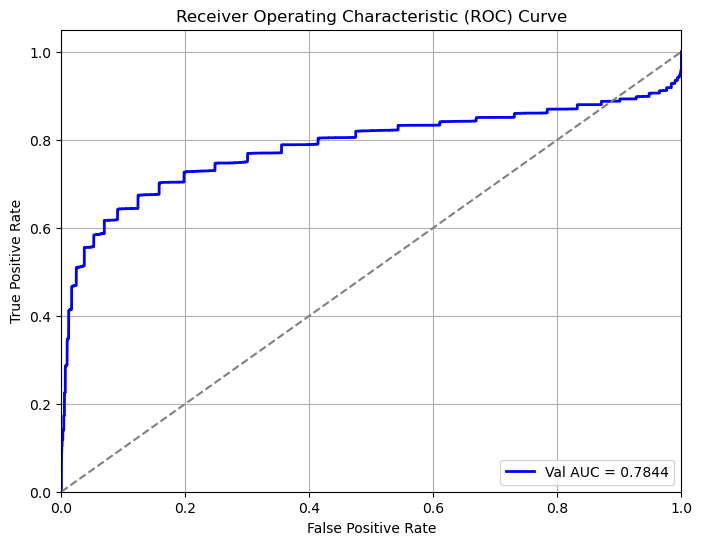

0.7844182882028585

In [30]:
test_with_graph(test_graph_data)

In [31]:
@torch.no_grad()
def test_model(data):
    model.eval()
    pred_pos = model(graph_data.x, graph_data.edge_index).squeeze()
    
     # Predictions for negative samples
    edge_index_neg = negative_sampling(graph_data.edge_index, num_nodes=graph_data.num_nodes, num_neg_samples=graph_data.edge_index.size(1))
    pred_neg = model(graph_data.x, edge_index_neg).squeeze()

    # Combine positive and negative predictions and create labels accordingly
    pred_all = torch.cat([pred_pos, pred_neg], dim=0)
    labels = torch.cat([torch.ones(pred_pos.size(0)), torch.zeros(pred_neg.size(0))], dim=0)

    return roc_auc_score(labels, pred_all)

In [34]:
def t():
    return test_model(test_graph_data)
train_model(20, t)


Epoch 1: Loss = 0.8217870593070984 Test = 0.6186759701690565
Epoch 2: Loss = 0.8433131575584412 Test = 0.5606029358842823
Epoch 3: Loss = 0.7862846255302429 Test = 0.4242196424303504
Epoch 4: Loss = 0.8430045247077942 Test = 0.5151604960373537
Epoch 5: Loss = 0.662079930305481 Test = 0.5211482564083456
Epoch 6: Loss = 0.6610845327377319 Test = 0.4292492009730998
Epoch 7: Loss = 0.6279478073120117 Test = 0.44588745375549466
Epoch 8: Loss = 0.6035243272781372 Test = 0.5300058512760348
Epoch 9: Loss = 0.5907379984855652 Test = 0.4663955458055745
Epoch 10: Loss = 0.5761097073554993 Test = 0.6267720244710792
Epoch 11: Loss = 0.5557090640068054 Test = 0.8449207947829926
Epoch 12: Loss = 0.5331160426139832 Test = 0.9428694914399387
Epoch 13: Loss = 0.529288113117218 Test = 0.5179664049741867
Epoch 14: Loss = 0.5391862988471985 Test = 0.8858570932323763
Epoch 15: Loss = 0.5633498430252075 Test = 0.8413390891138777
Epoch 16: Loss = 0.5937395095825195 Test = 0.9205941175080722
Epoch 17: Loss = 0

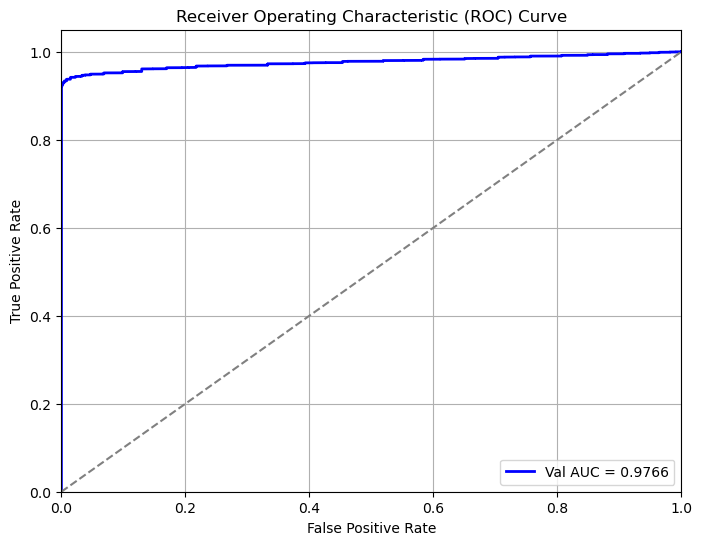

0.9765530326089404

In [35]:
test_with_graph(test_graph_data)

In [37]:
pip install torchviz

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 270.3 kB/s eta 0:00:00MB/s eta 0:00:01
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4131 sha256=cdc7d10e41f83fb0d53ead6ca07483a463bda90048601dd05216c24a00598e4b
  Stored in directory: /Users/fateme/Library/Caches/pip/wheels/29/65/6e/db2515eb1dc760fecd36b40d54df65c1e18534013f1c037e2e
Successfully built torchviz
Note: you may need to restart the kernel to use updated packages.
